In [38]:
import cv2
import os
import glob
from PIL import Image

In [67]:
def get_relative_file_paths(directory, root_folder):
    root_folder_abs_path = os.path.abspath(root_folder)
    all_files = glob.glob(os.path.join(directory, '*/*'), recursive=True)
    relative_paths = [
        os.path.relpath(file, root_folder_abs_path)
        for file in all_files if os.path.isfile(file)
    ]
    no_files = glob.glob(os.path.join(directory, 'no/*'), recursive=True)
    no_relative_paths = [
        os.path.relpath(file, root_folder_abs_path)
        for file in no_files if os.path.isfile(file)
    ]

    yes_files = glob.glob(os.path.join(directory, 'yes/*'), recursive=True)
    yes_relative_paths = [
        os.path.relpath(file, root_folder_abs_path)
        for file in yes_files if os.path.isfile(file)
    ]

    no_data = {}
    for path in no_relative_paths:
        no_data[path] = 0

    yes_data = {}
    for path in yes_relative_paths:
        yes_data[path] = 1

    all_data = {**yes_data, **no_data}


    print('All files:', len(relative_paths))
    print('Class yes:', len(yes_relative_paths))
    print('Class no:', len(no_relative_paths))

    print('Yes Data:', yes_data)
    print('No Data:', no_data)
    print('All Data:', all_data)
    
    return all_data

directory = '../input/data/steering_wheel/resized'  
root_folder = '../'

all_data = get_relative_file_paths(directory, root_folder)

All files: 103
Class yes: 70
Class no: 33
Yes Data: {'data/steering_wheel/resized/yes/63.jpg': 1, 'data/steering_wheel/resized/yes/62.jpg': 1, 'data/steering_wheel/resized/yes/60.jpg': 1, 'data/steering_wheel/resized/yes/48.jpg': 1, 'data/steering_wheel/resized/yes/49.jpg': 1, 'data/steering_wheel/resized/yes/61.jpg': 1, 'data/steering_wheel/resized/yes/59.jpg': 1, 'data/steering_wheel/resized/yes/71.jpg': 1, 'data/steering_wheel/resized/yes/65.jpg': 1, 'data/steering_wheel/resized/yes/64.jpg': 1, 'data/steering_wheel/resized/yes/70.jpg': 1, 'data/steering_wheel/resized/yes/58.jpg': 1, 'data/steering_wheel/resized/yes/8.jpg': 1, 'data/steering_wheel/resized/yes/66.jpg': 1, 'data/steering_wheel/resized/yes/72.jpg': 1, 'data/steering_wheel/resized/yes/67.jpg': 1, 'data/steering_wheel/resized/yes/9.jpg': 1, 'data/steering_wheel/resized/yes/14.jpg': 1, 'data/steering_wheel/resized/yes/28.jpg': 1, 'data/steering_wheel/resized/yes/29.jpg': 1, 'data/steering_wheel/resized/yes/15.jpg': 1, 'dat

In [99]:
import numpy as np
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import os

# Define paths and labels
data_dir = '../input/data/steering_wheel/resized/'
yes_dir = os.path.join(data_dir, 'yes')
no_dir = os.path.join(data_dir, 'no')

yes_files = [os.path.join(yes_dir, f) for f in os.listdir(yes_dir) if f.endswith('.jpg')]
no_files = [os.path.join(no_dir, f) for f in os.listdir(no_dir) if f.endswith('.jpg')]

file_paths = yes_files + no_files
labels = np.array([1] * len(yes_files) + [0] * len(no_files))

# Data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),
])

def load_and_augment_images(file_paths, labels, augment_times=5, save_dir='../input/data/steering_wheel/augmented_images'):
    augmented_images = []
    augmented_labels = []

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for idx, (file_path, label) in enumerate(zip(file_paths, labels)):
        img = Image.open(file_path)


        # Add original image to dataset
        original_image = transform(img)
        original_save_path = os.path.join(save_dir, f'{idx}_original.jpg')
        original_image_pil = transforms.ToPILImage()(original_image)
        original_image_pil.save(original_save_path)

        augmented_images.append(original_image)
        augmented_labels.append(label)

        # Apply augmentation multiple times
        for i in range(augment_times):
            augmented_image = transform(img)

            # Save the augmented image
            augmented_save_path = os.path.join(save_dir, f'{idx}_augmented_{i}.jpg')
            augmented_image_pil = transforms.ToPILImage()(augmented_image)
            augmented_image_pil.save(augmented_save_path)

            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return torch.stack(augmented_images), np.array(augmented_labels)


# Load and augment images
X_augmented, y_augmented = load_and_augment_images(file_paths, labels, augment_times=5)

# Split dataset into train, validation, and test sets
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=test_size, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

X_train, X_val, X_test = torch.tensor(X_train), torch.tensor(X_val), torch.tensor(X_test)
y_train, y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: torch.Size([324, 1, 128, 128]), y_train shape: torch.Size([324])
X_val shape: torch.Size([36, 1, 128, 128]), y_val shape: torch.Size([36])
X_test shape: torch.Size([90, 1, 128, 128]), y_test shape: torch.Size([90])


/var/folders/pc/5jkxyq3s4xb26zff0_pshj400000gn/T/ipykernel_6035/451323169.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_val, X_test = torch.tensor(X_train), torch.tensor(X_val), torch.tensor(X_test)


In [116]:
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Adjust input channels to 1 for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 128 * 128, 128)  # Corrected input size
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = x.view(-1, 64 * 128 * 128)  # Adjusted to match conv2 output channels
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.softmax(self.fc2(x), dim=1)
        return x


In [117]:
print(CNN())

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1048576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [118]:
from tqdm import tqdm  # Import tqdm
model = CNN()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Training parameters
epochs = 50
patience = 3
best_val_loss = float('inf')
early_stop_counter = 0

# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with tqdm
for epoch in range(epochs):
    # Train mode
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Iterate over training data directly
    tqdm_train = tqdm(range(len(X_train)), desc=f'Epoch {epoch + 1}/{epochs}', leave=True)
    for idx in tqdm_train:
        inputs, label = X_train[idx].unsqueeze(0), torch.tensor(y_train[idx]).unsqueeze(0)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += 1
        correct_train += (predicted == label).sum().item()
        
        # Update tqdm description with current loss and accuracy
        tqdm_train.set_postfix({
            'Train Loss': running_train_loss / total_train,
            'Train Acc': 100 * correct_train / total_train
        })
    
    epoch_train_loss = running_train_loss / len(X_train)
    train_acc = 100 * correct_train / len(X_train)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_acc)
    
    # Validation mode
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    # Iterate over validation data directly
    tqdm_val = tqdm(range(len(X_val)), desc=f'Validation {epoch + 1}/{epochs}', leave=True)
    with torch.no_grad():
        for idx in tqdm_val:
            inputs, label = X_val[idx].unsqueeze(0), torch.tensor(y_val[idx]).unsqueeze(0)
            
            outputs = model(inputs)
            loss = criterion(outputs, label)
            
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += 1
            correct_val += (predicted == label).sum().item()
            
            # Update tqdm description with current loss and accuracy
            tqdm_val.set_postfix({
                'Val Loss': running_val_loss / total_val,
                'Val Acc': 100 * correct_val / total_val
            })
    
    epoch_val_loss = running_val_loss / len(X_val)
    val_acc = 100 * correct_val / len(X_val)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping after epoch {epoch + 1} as validation loss did not improve.')
            break

print('Training finished.')

Epoch 1/50:   0%|          | 0/324 [00:00<?, ?it/s]/var/folders/pc/5jkxyq3s4xb26zff0_pshj400000gn/T/ipykernel_6035/3696479046.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, label = X_train[idx].unsqueeze(0), torch.tensor(y_train[idx]).unsqueeze(0)
Validation 1/50:   0%|          | 0/36 [00:00<?, ?it/s]/var/folders/pc/5jkxyq3s4xb26zff0_pshj400000gn/T/ipykernel_6035/3696479046.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, label = X_val[idx].unsqueeze(0), torch.tensor(y_val[idx]).unsqueeze(0)
Validation 1/50: 100%|██████████| 36/36 [00:04<00:00,  8.98it/s, Val Loss=0.869, Val Acc=44.4]


Epoch 1/50, Train Loss: 0.8763, Val Loss: 0.8688, Train Acc: 43.52%, Val Acc: 44.44%


Validation 2/50: 100%|██████████| 36/36 [00:02<00:00, 12.68it/s, Val Loss=0.869, Val Acc=44.4]


Epoch 2/50, Train Loss: 0.8750, Val Loss: 0.8688, Train Acc: 43.83%, Val Acc: 44.44%


Validation 3/50: 100%|██████████| 36/36 [00:03<00:00, 11.88it/s, Val Loss=0.869, Val Acc=44.4]


Epoch 3/50, Train Loss: 0.8750, Val Loss: 0.8688, Train Acc: 43.83%, Val Acc: 44.44%


Validation 4/50: 100%|██████████| 36/36 [00:09<00:00,  3.90it/s, Val Loss=0.869, Val Acc=44.4]

Epoch 4/50, Train Loss: 0.8750, Val Loss: 0.8688, Train Acc: 43.83%, Val Acc: 44.44%
Early stopping after epoch 4 as validation loss did not improve.
Training finished.


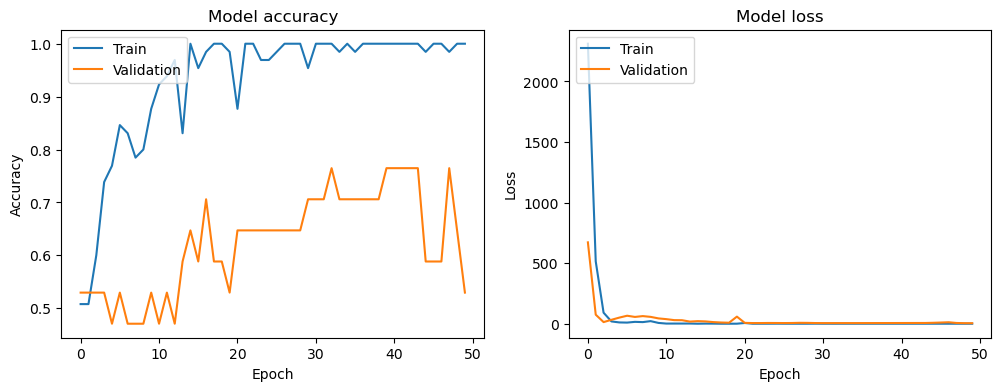

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6190 - loss: 10.4789
Test accuracy: 0.6190476417541504
Test loss: 10.478888511657715


In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')

In [32]:
model.save('model/trained_model/saved_model.h5')